In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
sns.set()

plt.rcParams['figure.figsize'] = [5.0, 4.0]
plt.rcParams['figure.dpi'] = 120

# Loading data

In [2]:
X_train_full = pd.read_csv('data\\training_set_features.csv', index_col = 'respondent_id')
y_train_full = pd.read_csv('data\\training_set_labels.csv', index_col = 'respondent_id')

Joining X and y for plotting simplicity:

In [3]:
train_df = X_train_full.join(y_train_full)

In [4]:
X_test = pd.read_csv('data\\test_set_features.csv', index_col = 'respondent_id')

# Exploratory Data Analysis

In this notebook, we want to explore the data through statistics and visualizations that help us draw insight from the raw data which can then be applied to preprocessing and feature engineering to help increase the accuracy of our predictions.

Lets begin by dividing the features in *numerical* and *categorical* since these require different approaches to visualization:

In [5]:
categorical_cols = [col for col in X_train_full.columns if X_train_full[col].dtype == 'object']
numerical_cols = [col for col in X_train_full.columns if col not in categorical_cols]
target_cols = ['h1n1_vaccine', 'seasonal_vaccine']

We can immediately plot the distribution of the targets and the numerical features:

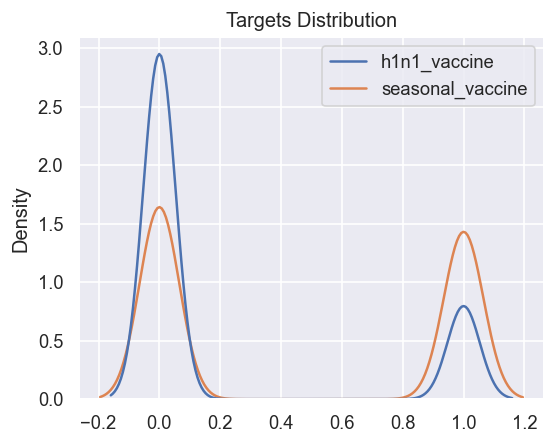

In [6]:
plt.figure()
plt.title('Targets Distribution')
sns.kdeplot(data=y_train_full);

From this image we can immediately see that someone is more likely to not take the H1N1 vaccine that to take it.

We can also see that the probability of taking the seasonal flu vaccine is more uniformly distributed.

Now we can start plotting the features.

Lets begin with the distribution of some categorical features for each of the targets:

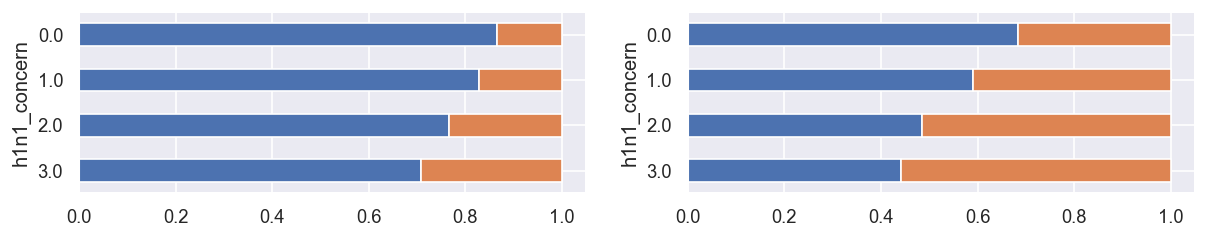

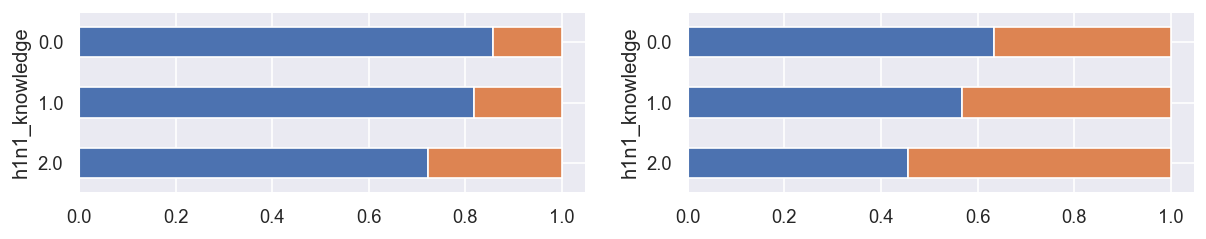

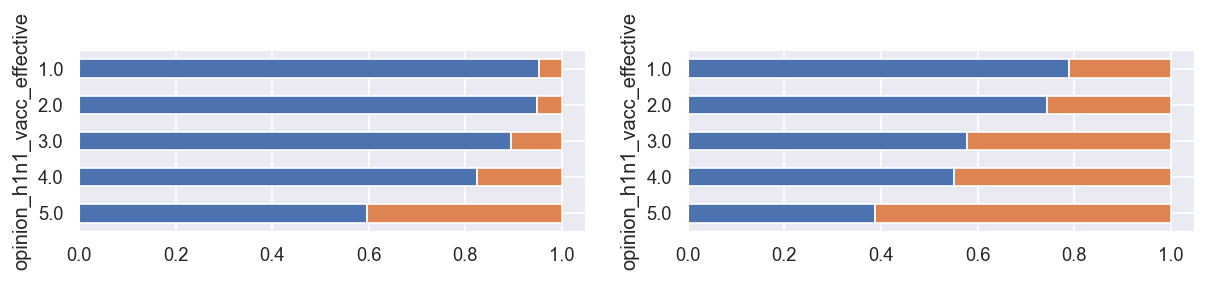

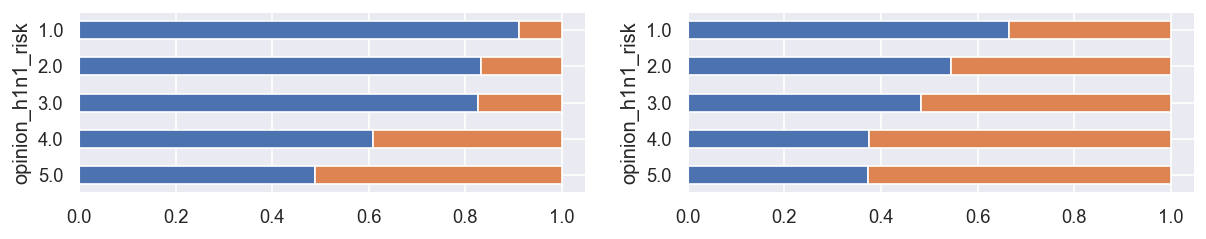

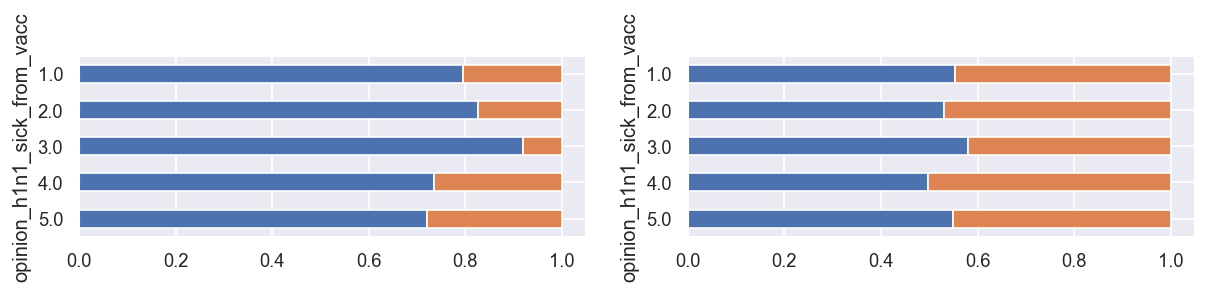

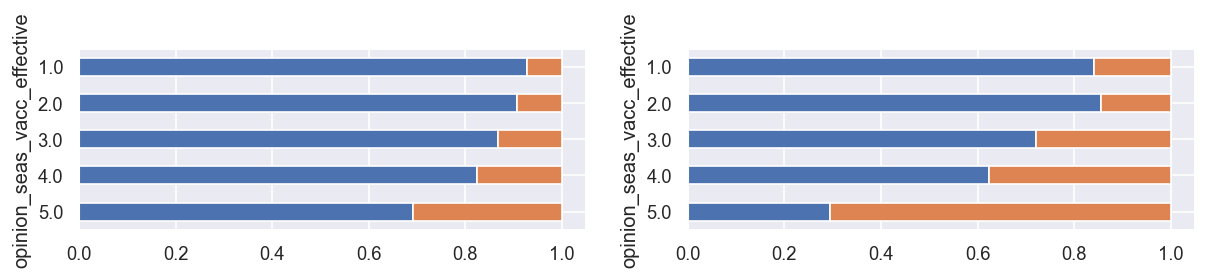

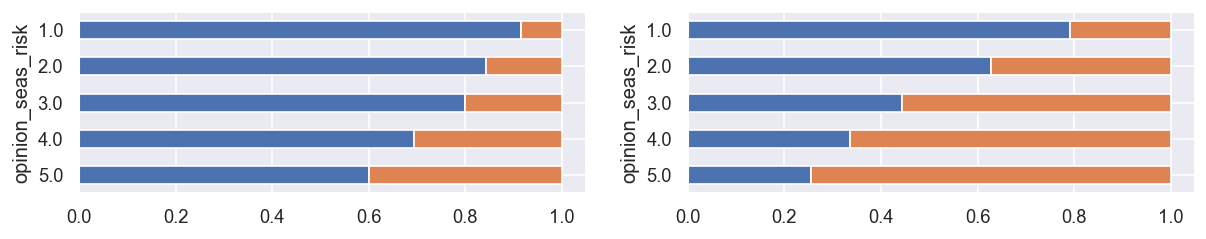

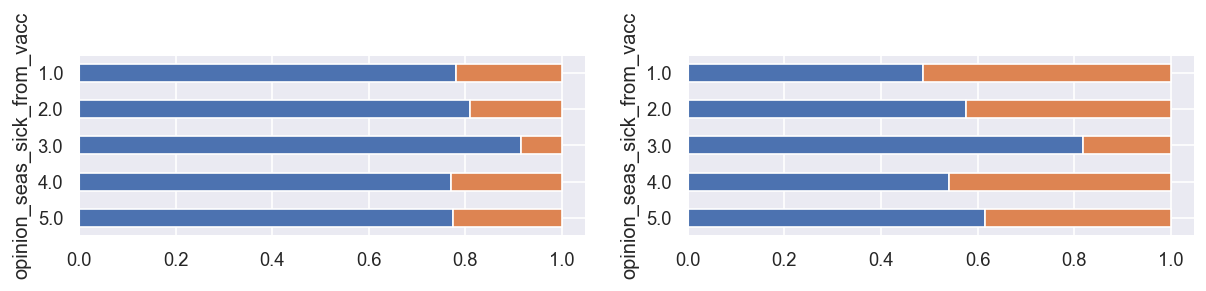

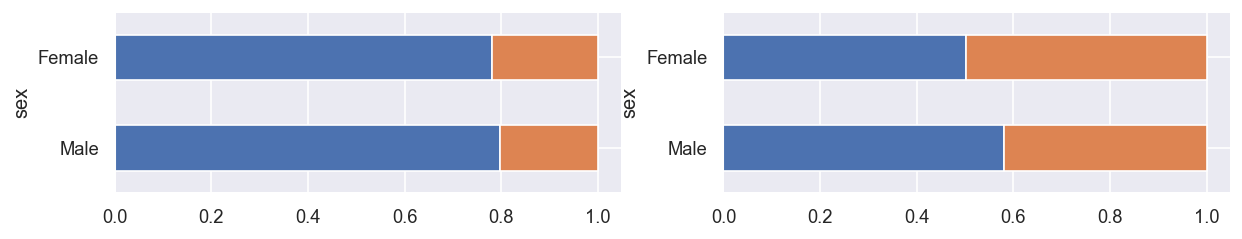

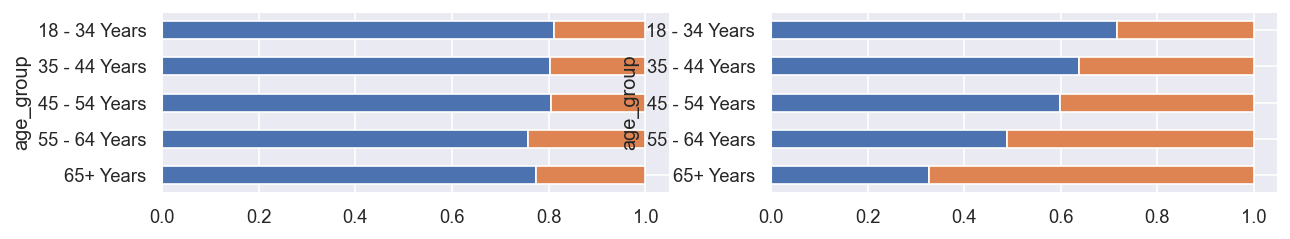

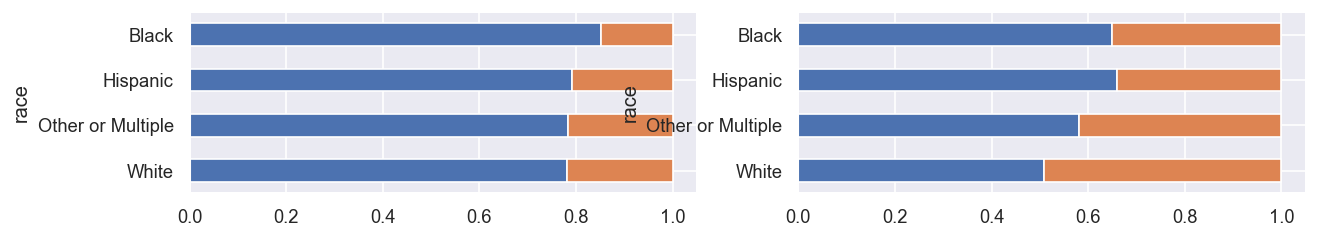

In [11]:
cols_to_plot = [
    'h1n1_concern',
    'h1n1_knowledge',
    'opinion_h1n1_vacc_effective',
    'opinion_h1n1_risk',
    'opinion_h1n1_sick_from_vacc',
    'opinion_seas_vacc_effective',
    'opinion_seas_risk',
    'opinion_seas_sick_from_vacc',
    'sex',
    'age_group',
    'race',
]

for i, col in enumerate(cols_to_plot):
    fig, axs = plt.subplots(1, 2, figsize = (12, 2))
    for j, target in enumerate(target_cols):
        counts = train_df[[target, col]].groupby([target, col]).size().unstack(target)
        counts_group = counts.sum(axis = 'columns')
        counts_percentage = counts.div(counts_group, axis = 'index')

        ax = axs.ravel()[j]
        counts_percentage.plot(kind="barh", stacked=True, ax=ax)
        ax.invert_yaxis()
        ax.legend().remove()